In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv("ai_maintaindataset.csv")

In [3]:
# Renaming raw CSV column names to make it easy for handeling

rename_map = {
    'Air temperature [K]': 'temperature',
    'Rotational speed [rpm]': 'vibration',
    'Torque [Nm]': 'pressure',
    'Machine failure': 'target'
}

# column renaming on the df
df = df.rename(columns=rename_map)

# Checking updated column names
df.columns

Index(['UDI', 'Product ID', 'Type', 'temperature', 'Process temperature [K]',
       'vibration', 'pressure', 'Tool wear [min]', 'target', 'TWF', 'HDF',
       'PWF', 'OSF', 'RNF'],
      dtype='object')

In [4]:
df.columns


Index(['UDI', 'Product ID', 'Type', 'temperature', 'Process temperature [K]',
       'vibration', 'pressure', 'Tool wear [min]', 'target', 'TWF', 'HDF',
       'PWF', 'OSF', 'RNF'],
      dtype='object')

In [5]:
# List of redundant columns
# TWF, HDF, PWF, OSF, RNF 
# remove them to avoid data leakage

cols_to_drop = [
    'Process temperature [K]',
    'TWF',
    'HDF',
    'PWF',
    'OSF',
    'RNF'
]

# Drop unwanted columns
# errors='ignore' to ensures the code is not crashed
# if any column is missing
df = df.drop(columns=cols_to_drop, errors='ignore')

# Check final columns
print("Columns ready for modeling:")
print(df.columns)

Columns ready for modeling:
Index(['UDI', 'Product ID', 'Type', 'temperature', 'vibration', 'pressure',
       'Tool wear [min]', 'target'],
      dtype='object')


In [6]:
# 2. infer_objects 
# converts 'object' columns to 'numeric' if contain numbers.
df = df.infer_objects(copy=False)

# 3.interpolation and other math tasks are safe
df = df.interpolate(method='linear')

C:\Users\hp\AppData\Local\Temp\ipykernel_19500\3594528956.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method='linear')


In [7]:
# 1. Identifing numeric columns that needs to be get cleaning
numeric_cols = df.select_dtypes(include=[np.number]).columns

# 2. Linear Interpolation
df[numeric_cols] = df[numeric_cols].interpolate(method='linear')

# 3. Back-filling (bfill)
df[numeric_cols] = df[numeric_cols].bfill()

# Verify that all missing values are filled 
print(f"Missing values remaining: {df.isnull().sum().sum()}")

Missing values remaining: 0


In [8]:
# Creating features for  1, 4, and 8 hours
windows = [1, 4, 8]

for w in windows:
   
    df[f'temp_mean_{w}h'] = df['temperature'].rolling(window=w).mean()
    df[f'vib_std_{w}h'] = df['vibration'].rolling(window=w).std()

# Creating lag feature
df['temp_lag_1'] = df['temperature'].shift(1)

In [9]:
df.head(5)

,UDI,Product ID,Type,temperature,vibration,pressure,Tool wear [min],target,temp_mean_1h,vib_std_1h,temp_mean_4h,vib_std_4h,temp_mean_8h,vib_std_8h,temp_lag_1
0,1,M14860,M,298.1,1551,42.8,0,0,298.1,NaN,NaN,NaN,NaN,NaN,NaN
1,2,L47181,L,298.2,1408,46.3,3,0,298.2,NaN,NaN,NaN,NaN,NaN,298.1
2,3,L47182,L,298.1,1498,49.4,5,0,298.1,NaN,NaN,NaN,NaN,NaN,298.2
3,4,L47183,L,298.2,1433,39.5,7,0,298.2,NaN,298.150,64.634872,NaN,NaN,298.1
4,5,L47184,L,298.2,1408,40.0,9,0,298.2,NaN,298.175,42.500000,NaN,NaN,298.2


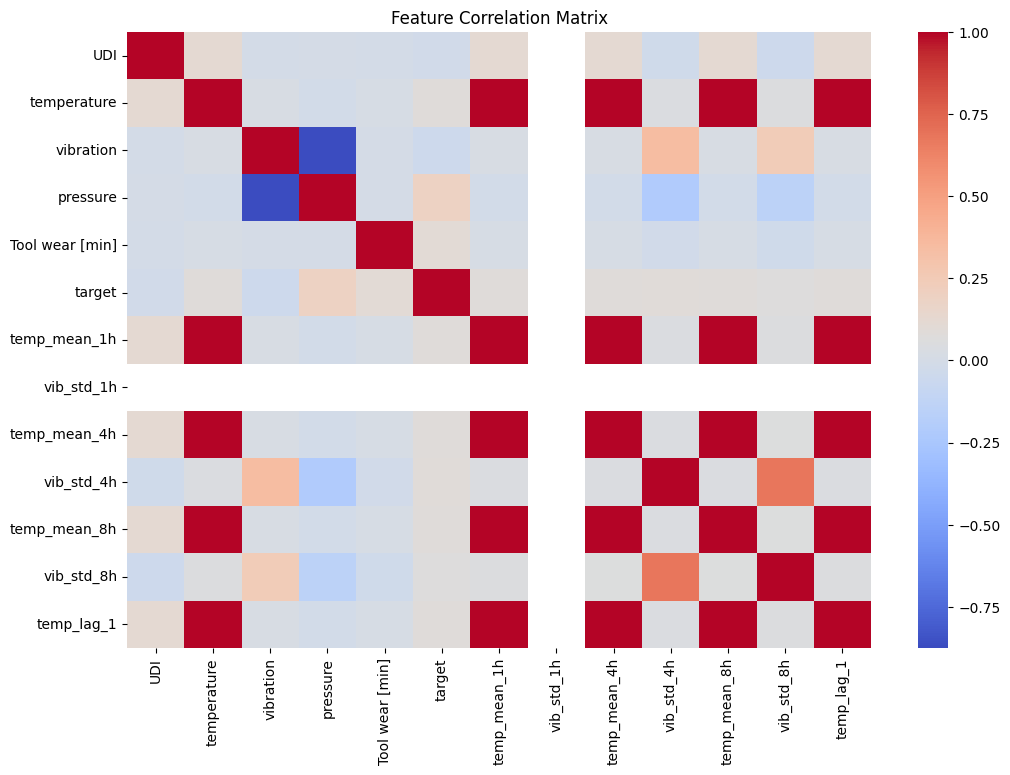

In [10]:
# Selecting only numeric columns 
numeric_df = df.select_dtypes(include=[np.number])

# Calculating the correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = numeric_df.corr()

# Plotting the correlation heatmap
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

In [11]:
# Droping rows having missing values
df.dropna(inplace=True)

# Verifying if missing values remain
total_missing = df.isnull().sum().sum()
print(f"Total missing values left in the dataset: {total_missing}")

# new size of the dataset 
print(f"Dataset shape after removing missing rows: {df.shape}")

Total missing values left in the dataset: 0
Dataset shape after removing missing rows: (0, 15)


In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# ------------------------------------------------
# Step 1: Load dataset
# ------------------------------------------------
data = pd.read_csv("ai_maintaindataset.csv")

# ------------------------------------------------
# Step 2: Rename important columns for clarity
# ------------------------------------------------
data.rename(columns={
    'Air temperature [K]': 'air_temp',
    'Rotational speed [rpm]': 'rot_speed',
    'Torque [Nm]': 'torque',
    'Machine failure': 'target'
}, inplace=True)

# ------------------------------------------------
# Step 3: Remove columns causing data leakage
# ------------------------------------------------
leakage_features = [
    'Process temperature [K]', 
    'TWF', 'HDF', 'PWF', 'OSF', 'RNF'
]
data.drop(columns=leakage_features, inplace=True, errors='ignore')

# ------------------------------------------------
# Step 4: Handle numerical missing values
# ------------------------------------------------
data = data.infer_objects(copy=False)

num_cols = data.select_dtypes(include=np.number).columns
data[num_cols] = data[num_cols].interpolate(method='linear')
data[num_cols] = data[num_cols].fillna(method='bfill')

# ------------------------------------------------
# Step 5: Generate time-based features
# ------------------------------------------------
rolling_windows = [2, 5, 10]

for window in rolling_windows:
    data[f'air_temp_avg_{window}'] = (
        data['air_temp'].rolling(window=window).mean()
    )

    if window > 2:
        data[f'rot_speed_var_{window}'] = (
            data['rot_speed'].rolling(window=window).std()
        )

# Lag feature to capture previous state
data['air_temp_prev'] = data['air_temp'].shift(1)

# ------------------------------------------------
# Step 6: Clean NaNs from feature engineering
# ------------------------------------------------
data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True)

print("Missing values after cleaning:", data.isnull().sum().sum())

# ------------------------------------------------
# Step 7: Encode categorical variable
# ------------------------------------------------
data = pd.get_dummies(data, columns=['Type'], drop_first=True)

# ------------------------------------------------
# Step 8: Split features and target
# ------------------------------------------------
X = data.drop(columns=['UDI', 'Product ID', 'target'])
y = data['target']

# ------------------------------------------------
# Step 9: Train-test split
# ------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# ------------------------------------------------
# Step 10: Verify dataset dimensions
# ------------------------------------------------
print("Training data:", X_train.shape, y_train.shape)
print("Testing data:", X_test.shape, y_test.shape)


Missing values after cleaning: 0
Training data: (8000, 12) (8000,)
Testing data: (2000, 12) (2000,)


C:\Users\hp\AppData\Local\Temp\ipykernel_19500\1936363091.py:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[num_cols] = data[num_cols].fillna(method='bfill')
C:\Users\hp\AppData\Local\Temp\ipykernel_19500\1936363091.py:59: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_19500\1936363091.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, f1_score, roc_auc_score

# ------------------------------------------------
# Step 1: Initialize Logistic Regression model
# ------------------------------------------------
# Balanced class weights help in detecting minority (failure) cases
lr_classifier = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced',
    solver='liblinear'
)

# ------------------------------------------------
# Step 2: Train model
# ------------------------------------------------
lr_classifier.fit(X_train, y_train)

# ------------------------------------------------
# Step 3: Generate predictions
# ------------------------------------------------
y_test_pred = lr_classifier.predict(X_test)
y_test_prob = lr_classifier.predict_proba(X_test)[:, 1]

# ------------------------------------------------
# Step 4: Evaluate model (Recall-focused)
# ------------------------------------------------
lr_recall = recall_score(y_test, y_test_pred)
lr_f1 = f1_score(y_test, y_test_pred)
lr_auc = roc_auc_score(y_test, y_test_prob)

# ------------------------------------------------
# Step 5: Display results
# ------------------------------------------------
print("\nLogistic Regression – Baseline Results")
print("-" * 40)
print(f"Recall Score : {lr_recall:.4f}")
print(f"F1 Score     : {lr_f1:.4f}")
print(f"ROC-AUC      : {lr_auc:.4f}")


Logistic Regression – Baseline Results
----------------------------------------
Recall Score : 0.7353
F1 Score     : 0.1988
ROC-AUC      : 0.8696


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, f1_score, roc_auc_score

# ------------------------------------------------
# Step 1: Initialize Random Forest model
# ------------------------------------------------
# Class weights are used to improve detection of rare failure cases
rf_classifier = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

# ------------------------------------------------
# Step 2: Train the model
# ------------------------------------------------
rf_classifier.fit(X_train, y_train)

# ------------------------------------------------
# Step 3: Make predictions
# ------------------------------------------------
rf_test_pred = rf_classifier.predict(X_test)
rf_test_prob = rf_classifier.predict_proba(X_test)[:, 1]

# ------------------------------------------------
# Step 4: Evaluate performance
# ------------------------------------------------
rf_recall = recall_score(y_test, rf_test_pred)
rf_f1 = f1_score(y_test, rf_test_pred)
rf_auc = roc_auc_score(y_test, rf_test_prob)

# ------------------------------------------------
# Step 5: Display results
# ------------------------------------------------
print("\nRandom Forest – Model Performance")
print("-" * 40)
print(f"Recall Score : {rf_recall:.4f}")
print(f"F1 Score     : {rf_f1:.4f}")
print(f"ROC-AUC      : {rf_auc:.4f}")



Random Forest – Model Performance
----------------------------------------
Recall Score : 0.3235
F1 Score     : 0.4731
ROC-AUC      : 0.9625


In [15]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [16]:
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, f1_score, roc_auc_score

# ------------------------------------------------
# Step 0: FORCE XGBoost-safe feature names
# (THIS FIXES THE ValueError)
# ------------------------------------------------
X_train = X_train.copy()
X_test = X_test.copy()

X_train.columns = [f"f_{i}" for i in range(X_train.shape[1])]
X_test.columns = X_train.columns

# ------------------------------------------------
# Step 1: Compute class imbalance ratio
# ------------------------------------------------
neg_class = (y_train == 0).sum()
pos_class = (y_train == 1).sum()
imbalance_ratio = neg_class / pos_class

print(f"Class imbalance ratio (scale_pos_weight): {imbalance_ratio:.2f}")

# ------------------------------------------------
# Step 2: Initialize XGBoost model
# ------------------------------------------------
xgb_classifier = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=imbalance_ratio,
    objective='binary:logistic',
    random_state=42,
    eval_metric='logloss'
)

# ------------------------------------------------
# Step 3: Train the model
# ------------------------------------------------
xgb_classifier.fit(X_train, y_train)

# ------------------------------------------------
# Step 4: Make predictions
# ------------------------------------------------
xgb_test_pred = xgb_classifier.predict(X_test)
xgb_test_prob = xgb_classifier.predict_proba(X_test)[:, 1]

# ------------------------------------------------
# Step 5: Evaluate performance
# ------------------------------------------------
xgb_recall = recall_score(y_test, xgb_test_pred)
xgb_f1 = f1_score(y_test, xgb_test_pred)
xgb_auc = roc_auc_score(y_test, xgb_test_prob)

# ------------------------------------------------
# Step 6: Display results
# ------------------------------------------------
print("\nXGBoost – Initial Model Performance")
print("-" * 45)
print(f"Recall Score : {xgb_recall:.4f}")
print(f"F1 Score     : {xgb_f1:.4f}")
print(f"ROC-AUC      : {xgb_auc:.4f}")


Class imbalance ratio (scale_pos_weight): 28.52

XGBoost – Initial Model Performance
---------------------------------------------
Recall Score : 0.8088
F1 Score     : 0.6077
ROC-AUC      : 0.9640


In [17]:
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, f1_score, roc_auc_score

# ------------------------------------------------
# Step 1: Standardize feature names for XGBoost
# ------------------------------------------------
def standardize_columns(df):
    df = df.copy()
    df.columns = (
        df.columns
        .str.replace(r'[\[\]<>():]', '', regex=True)
        .str.replace(' ', '_')
    )
    return df

X_train = standardize_columns(X_train)
X_test = standardize_columns(X_test)

# ------------------------------------------------
# Step 2: Compute class imbalance weight
# ------------------------------------------------
negative_count = (y_train == 0).sum()
positive_count = (y_train == 1).sum()
pos_weight = negative_count / positive_count

print(f"XGBoost scale_pos_weight: {pos_weight:.2f}")

# ------------------------------------------------
# Step 3: Initialize XGBoost classifier
# ------------------------------------------------
xgb_classifier = XGBClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='binary:logistic',
    scale_pos_weight=pos_weight,
    random_state=42,
    eval_metric='logloss'
)

# ------------------------------------------------
# Step 4: Train model
# ------------------------------------------------
xgb_classifier.fit(X_train, y_train)

# ------------------------------------------------
# Step 5: Generate predictions
# ------------------------------------------------
xgb_pred = xgb_classifier.predict(X_test)
xgb_prob = xgb_classifier.predict_proba(X_test)[:, 1]

# ------------------------------------------------
# Step 6: Evaluate performance
# ------------------------------------------------
xgb_recall = recall_score(y_test, xgb_pred)
xgb_f1 = f1_score(y_test, xgb_pred)
xgb_auc = roc_auc_score(y_test, xgb_prob)

# ------------------------------------------------
# Step 7: Display results
# ------------------------------------------------
print("\nXGBoost – Baseline Results")
print("-" * 40)
print(f"Recall Score : {xgb_recall:.4f}")
print(f"F1 Score     : {xgb_f1:.4f}")
print(f"ROC-AUC      : {xgb_auc:.4f}")


XGBoost scale_pos_weight: 28.52

XGBoost – Baseline Results
----------------------------------------
Recall Score : 0.6029
F1 Score     : 0.5694
ROC-AUC      : 0.9607


In [18]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from scipy.stats import uniform, randint

# --- Step 1: Handle Class Imbalance ---
# Calculate scale_pos_weight to balance classes automatically
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale positive weight for XGBoost: {scale_pos_weight:.2f}")

# --- Step 2: Define Parameter Distributions ---
param_distributions = {
    'learning_rate': uniform(0.01, 0.29),   # 0.01 to 0.30
    'max_depth': randint(3, 11),            # integer values 3-10
    'subsample': uniform(0.5, 0.5),         # 0.5 to 1.0
    'colsample_bytree': uniform(0.5, 0.5),  # 0.5 to 1.0
    'n_estimators': randint(100, 1001)      # 100 to 1000
}

# --- Step 3: Clean Column Names for XGBoost ---
def clean_columns(df):
    """Replace problematic characters in column names."""
    df = df.copy()
    df.columns = (
        df.columns
        .str.replace(r'[\[\]<>()]', '', regex=True)  # Use raw string to avoid warnings
        .str.replace(' ', '_')
    )
    return df

X_train_cleaned = clean_columns(X_train)

# --- Step 4: Initialize Base XGBoost Classifier ---
xgb_model = XGBClassifier(
    random_state=42,
    eval_metric='logloss',       # Standard for classification
    scale_pos_weight=scale_pos_weight,
    tree_method='hist'           # Fast histogram-based method
)

# --- Step 5: Setup RandomizedSearchCV ---
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50,          # Number of random hyperparameter sets to try
    scoring='roc_auc',  # Optimize for AUC because of class imbalance
    cv=5,               # 5-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1           # Use all available CPU cores
)

# --- Step 6: Run RandomizedSearchCV ---
print("Running RandomizedSearchCV, this may take a while...")
random_search.fit(X_train_cleaned, y_train)
print("RandomizedSearchCV finished!")

# --- Step 7: Show Best Hyperparameters ---
print("\nBest hyperparameters found:")
print(random_search.best_params_)


Scale positive weight for XGBoost: 28.52
Running RandomizedSearchCV, this may take a while...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
RandomizedSearchCV finished!

Best hyperparameters found:
{'colsample_bytree': np.float64(0.9303652916281717), 'learning_rate': np.float64(0.012016117854045303), 'max_depth': 10, 'n_estimators': 510, 'subsample': np.float64(0.7087055015743895)}


In [19]:
from sklearn.metrics import recall_score, f1_score, roc_auc_score

# --- Step 1: Get best hyperparameters from RandomizedSearchCV ---
best_params = random_search.best_params_
print("Best hyperparameters found:", best_params)

# --- Step 2: Instantiate XGBoost with tuned parameters ---
xgb_tuned = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    tree_method='hist',
    **best_params
)

# --- Step 3: Train the tuned XGBoost model ---
xgb_tuned.fit(X_train_cleaned, y_train)

# --- Step 4: Clean test data columns ---
X_test_cleaned = clean_columns(X_test)

# --- Step 5: Make predictions ---
y_pred = xgb_tuned.predict(X_test_cleaned)
y_pred_proba = xgb_tuned.predict_proba(X_test_cleaned)[:, 1]  # Positive class probabilities

# --- Step 6: Evaluate the model ---
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

# --- Step 7: Print evaluation metrics ---
print("\nTuned XGBoost Classifier Performance on Test Set:")
print(f"  Recall : {recall:.4f}")
print(f"  F1-score : {f1:.4f}")
print(f"  AUC : {auc:.4f}")


Best hyperparameters found: {'colsample_bytree': np.float64(0.9303652916281717), 'learning_rate': np.float64(0.012016117854045303), 'max_depth': 10, 'n_estimators': 510, 'subsample': np.float64(0.7087055015743895)}

Tuned XGBoost Classifier Performance on Test Set:
  Recall : 0.6471
  F1-score : 0.6069
  AUC : 0.9690


Recall: 0.6471
F1-score: 0.6069
AUC: 0.9690

Model Performance Table:
| Model           |   Recall |   F1-score |      AUC |
|:----------------|---------:|-----------:|---------:|
| XGBoost (Tuned) | 0.647059 |   0.606897 | 0.968959 |


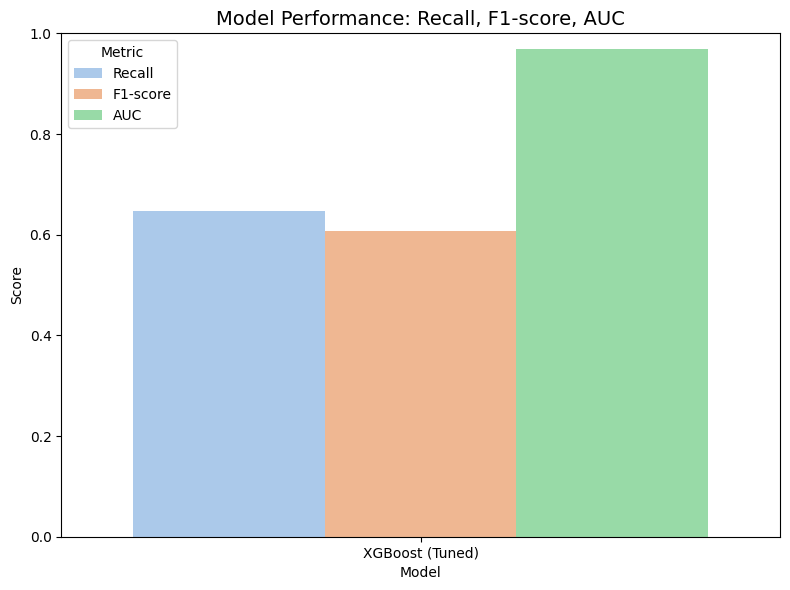

In [27]:
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, f1_score, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 0: Clean columns ---
def clean_columns(df):
    df = df.copy()
    df.columns = (
        df.columns
        .str.replace(r'[\[\]<>()]', '', regex=True)
        .str.replace(' ', '_')
    )
    return df

X_train_cleaned = clean_columns(X_train)
X_test_cleaned = clean_columns(X_test)

# --- Step 1: Train tuned XGBoost model ---
# Replace 'best_params' with the actual parameters from your RandomizedSearchCV
xgb_tuned = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=(y_train==0).sum() / (y_train==1).sum(),
    tree_method='hist',
    **best_params  # Make sure best_params exists
)

xgb_tuned.fit(X_train_cleaned, y_train)

# --- Step 2: Predict and calculate metrics ---
y_pred = xgb_tuned.predict(X_test_cleaned)
y_pred_proba = xgb_tuned.predict_proba(X_test_cleaned)[:, 1]

recall_xgb_tuned = recall_score(y_test, y_pred)
f1_xgb_tuned = f1_score(y_test, y_pred)
auc_xgb_tuned = roc_auc_score(y_test, y_pred_proba)

print(f"Recall: {recall_xgb_tuned:.4f}")
print(f"F1-score: {f1_xgb_tuned:.4f}")
print(f"AUC: {auc_xgb_tuned:.4f}")

# --- Step 3: Create performance table ---
performance_data = {
    'Model': ['XGBoost (Tuned)'],
    'Recall': [recall_xgb_tuned],
    'F1-score': [f1_xgb_tuned],
    'AUC': [auc_xgb_tuned]
}

metrics_df = pd.DataFrame(performance_data)
print("\nModel Performance Table:")
print(metrics_df.to_markdown(index=False))

# --- Step 4: Plot performance ---
metrics_melted = metrics_df.melt(id_vars=['Model'], var_name='Metric', value_name='Score')

plt.figure(figsize=(8,6))
sns.barplot(x='Model', y='Score', hue='Metric', data=metrics_melted, palette='pastel')
plt.title('Model Performance: Recall, F1-score, AUC', fontsize=14)
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


c:\Users\hp\Desktop\infotact\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Model Performance Table:
| Model               |   Recall |   F1-score |      AUC |
|:--------------------|---------:|-----------:|---------:|
| Logistic Regression | 0.794118 |   0.222222 | 0.887833 |
| Random Forest       | 0.426471 |   0.54717  | 0.96177  |
| XGBoost (Initial)   | 0.573529 |   0.549296 | 0.963707 |
| XGBoost (Tuned)     | 0.647059 |   0.606897 | 0.968959 |


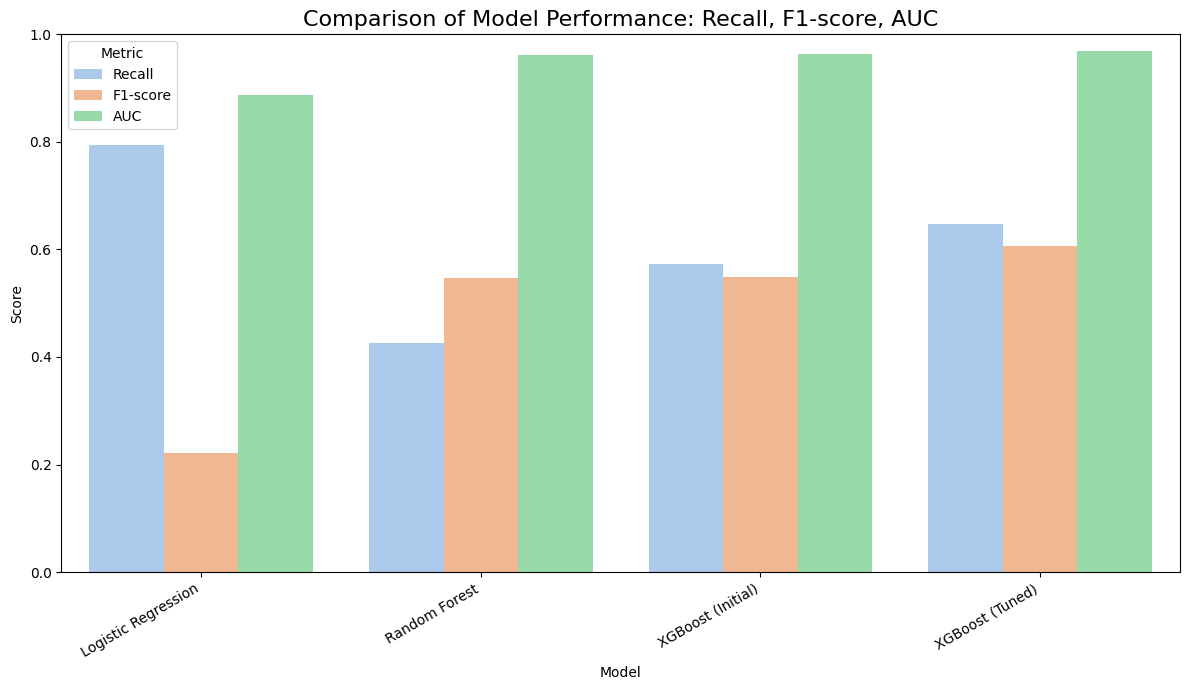

In [28]:
# --- Step 0: Imports ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, f1_score, roc_auc_score

# --- Step 1: Clean column names ---
def clean_columns(df):
    df = df.copy()
    df.columns = (
        df.columns
        .str.replace(r'[\[\]<>()]', '', regex=True)
        .str.replace(' ', '_')
    )
    return df

X_train_cleaned = clean_columns(X_train)
X_test_cleaned = clean_columns(X_test)

# --- Step 2: Define scale_pos_weight for XGBoost ---
scale_pos_weight = (y_train==0).sum() / (y_train==1).sum()

# --- Step 3: Train models ---

# Logistic Regression
lr_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
lr_model.fit(X_train_cleaned, y_train)
y_pred_lr = lr_model.predict(X_test_cleaned)
y_proba_lr = lr_model.predict_proba(X_test_cleaned)[:, 1]

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_cleaned, y_train)
y_pred_rf = rf_model.predict(X_test_cleaned)
y_proba_rf = rf_model.predict_proba(X_test_cleaned)[:, 1]

# Initial XGBoost (default parameters)
xgb_initial = XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=scale_pos_weight, tree_method='hist')
xgb_initial.fit(X_train_cleaned, y_train)
y_pred_xgb = xgb_initial.predict(X_test_cleaned)
y_proba_xgb = xgb_initial.predict_proba(X_test_cleaned)[:, 1]

# Tuned XGBoost (replace best_params with your RandomizedSearchCV output)
xgb_tuned = XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=scale_pos_weight, tree_method='hist', **best_params)
xgb_tuned.fit(X_train_cleaned, y_train)
y_pred_xgb_tuned = xgb_tuned.predict(X_test_cleaned)
y_proba_xgb_tuned = xgb_tuned.predict_proba(X_test_cleaned)[:, 1]

# --- Step 4: Calculate metrics ---
metrics = {
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost (Initial)', 'XGBoost (Tuned)'],
    'Recall': [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_xgb),
        recall_score(y_test, y_pred_xgb_tuned)
    ],
    'F1-score': [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb),
        f1_score(y_test, y_pred_xgb_tuned)
    ],
    'AUC': [
        roc_auc_score(y_test, y_proba_lr),
        roc_auc_score(y_test, y_proba_rf),
        roc_auc_score(y_test, y_proba_xgb),
        roc_auc_score(y_test, y_proba_xgb_tuned)
    ]
}

metrics_df = pd.DataFrame(metrics)

# --- Step 5: Print table ---
print("\nModel Performance Table:")
print(metrics_df.to_markdown(index=False))

# --- Step 6: Plot grouped bar chart ---
metrics_melted = metrics_df.melt(id_vars=['Model'], var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 7))
sns.barplot(x='Model', y='Score', hue='Metric', data=metrics_melted, palette='pastel')
plt.title('Comparison of Model Performance: Recall, F1-score, AUC', fontsize=16)
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=30, ha='right')
plt.legend(title='Metric', fontsize=10)
plt.tight_layout()
plt.show()


In [29]:
pip install shap


Note: you may need to restart the kernel to use updated packages.


In [34]:
%pip install "numpy<2"


^C
Note: you may need to restart the kernel to use updated packages.


   ---------------------------------------- 0.0/15.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/15.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/15.8 MB ? eta -:--:--
    --------------------------------------- 0.3/15.8 MB ? eta -:--:--
    --------------------------------------- 0.3/15.8 MB ? eta -:--:--
    --------------------------------------- 0.3/15.8 MB ? eta -:--:--
   - -------------------------------------- 0.5/15.8 MB 409.0 kB/s eta 0:00:38
   - -------------------------------------- 0.5/15.8 MB 409.0 kB/s eta 0:00:38
   - -------------------------------------- 0.5/15.8 MB 409.0 kB/s eta 0:00:38
   - -------------------------------------- 0.5/15.8 MB 409.0 kB/s eta 0:00:38
   - -------------------------------------- 0.5/15.8 MB 409.0 kB/s eta 0:00:38
   - -------------------------------------- 0.5/15.8 MB 409.0 kB/s eta 0:00:38
   - -------------------------------------- 0.8/15.8 MB 294.4 kB/s eta 0:00:52
   - ----------------------

In [30]:
import shap
import matplotlib.pyplot as plt


c:\Users\hp\Desktop\infotact\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
# xgb_tuned is your final trained model
# X_test_cleaned is your test dataset


In [33]:
# Upgrade pip, setuptools, wheel
!python -m pip install --upgrade pip setuptools wheel

# Reinstall NumPy, SHAP, and XGBoost
!pip uninstall numpy shap xgboost -y
!pip install numpy shap xgboost --no-cache-dir




   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   --------- ------------------------------ 0.3/1.1 MB ? eta -:--:--
   --------- ------------------------------ 0.3/1.1 MB ? eta -:--:--
   --------- ------------------------------ 0.3/1.1 MB ? eta -:--:--
   ------------------- -------------------- 0.5/1.1 MB 357.1 kB/s eta 0:00:02
   ------------------- --

You can safely remove it manually.
You can safely remove it manually.
You can safely remove it manually.
You can safely remove it manually.
You can safely remove it manually.


   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
    --------------------------------------- 0.3/12.9 MB ? eta -:--:--
    --------------------------------------- 0.3/12.9 MB ? eta -:--:--
    --------------------------------------- 0.3/12.9 MB ? eta -:--:--
    --------------------------------------- 0.3/12.9 MB ? eta -:--:--
    --------------------------------------- 0.3/12.9 MB ? eta -:--:--
    --------------------------------------- 0.3/12.9 MB ? eta -:--:--
    --------------------------------------- 0.3/12.9 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.9 MB 180.3 kB/s eta 0:01:09
   - -------------------------------------- 0.5/12.9 MB 180.3 kB/s eta 0:01:09
  

In [5]:

import shap

explainer = shap.Explainer(xgb, X_train_cleaned)
shap_values = explainer(X_test_cleaned)


NameError: name 'xgb' is not defined

In [ ]:
import shap
explainer = shap.TreeExplainer(xgb_tuned)

C extension was not built during install!


ImportError: numpy._core.multiarray failed to import

In [ ]:
shap_values = explainer.shap_values(X_test_cleaned)


NameError: name 'explainer' is not defined

In [ ]:
shap.summary_plot(shap_values, X_test_cleaned)


NameError: name 'shap_values' is not defined

In [ ]:
shap.summary_plot(shap_values, X_test_cleaned, plot_type="bar")


NameError: name 'shap_values' is not defined

In [ ]:
shap_values = shap_values[1]  # class 1 = failure


NameError: name 'shap_values' is not defined

In [ ]:
explainer = shap.TreeExplainer(
    xgb_tuned,
    feature_perturbation="tree_path_dependent"
)


In [ ]:
shap_values = explainer.shap_values(X_test_cleaned)


In [ ]:
# For binary classification
if isinstance(shap_values, list):
    shap_values = shap_values[1]

# Ensure 2D
import numpy as np
shap_values = np.array(shap_values)


In [ ]:
print("SHAP shape:", shap_values.shape)
print("X_test shape:", X_test_cleaned.shape)



SHAP shape: (2000, 12)
X_test shape: (2000, 12)


In [ ]:
# Explain one failed prediction
index = 0

shap.force_plot(
    explainer.expected_value,
    shap_values[index].values,
    X_test_cleaned.iloc[index],
    matplotlib=True
)


NameError: name 'shap' is not defined